In [1]:
import os
import tarfile
import urllib.request

# Download the dataset
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'
dataset_path = './aclImdb_v1.tar.gz'
urllib.request.urlretrieve(url, dataset_path)

# Extract the dataset
with tarfile.open(dataset_path, 'r:gz') as tar:
    tar.extractall()

In [2]:
import pandas as pd

# Function to load data from a given path and sentiment
def load_data(path, sentiment):
    data = []
    for filename in os.listdir(path):
        with open(os.path.join(path, filename), 'r', encoding='utf-8') as file:
            data.append([file.read(), sentiment])
    return data

# Load train and test data
train_pos = load_data('./aclImdb/train/pos', 1)
train_neg = load_data('./aclImdb/train/neg', 0)
test_pos = load_data('./aclImdb/test/pos', 1)
test_neg = load_data('./aclImdb/test/neg', 0)

# Create DataFrames
train_data = train_pos + train_neg
test_data = test_pos + test_neg

df_train = pd.DataFrame(train_data, columns=['review', 'sentiment'])
df_test = pd.DataFrame(test_data, columns=['review', 'sentiment'])

# Combine train and test datasets for further processing
df = pd.concat([df_train, df_test], ignore_index=True)

# Display the first few rows of the DataFrame
df.head()


,review,sentiment
0,What i like about you is one of those series y...,1
1,Peter Sollett has created an endearing portrai...,1
2,"I must say as a girl with a cowboy of my own,I...",1
3,"This drama is unlike Sex and the City, where t...",1
4,"This movie started slowly, then gained momentu...",1


In [3]:
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure stopwords are downloaded
import nltk
nltk.download('stopwords')
nltk.download('punkt')

# Function to clean text
def clean_text(text):
    text = re.sub(r'<.*?>', '', text)  # Remove HTML tags
    text = text.lower()  # Lowercase text
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespace
    return text

# Clean the reviews
df['review'] = df['review'].apply(clean_text)

# Remove stopwords
stop_words = set(stopwords.words('english'))
df['review'] = df['review'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word not in stop_words))

# Display the first few rows of the cleaned DataFrame
df.head()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,review,sentiment
0,like one series need see sure would see beginn...,1
1,peter sollett created endearing portrait real ...,1
2,must say girl cowboy love flick left lovin boo...,1
3,drama unlike sex city women drinks share sexua...,1
4,movie started slowly gained momentum towards m...,1


In [4]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['sentiment'], test_size=0.2, random_state=42)

# Display the size of training and testing sets
len(X_train), len(X_test)


(40000, 10000)

In [5]:
# step 5 - Vectorize the Text Data
from sklearn.feature_extraction.text import TfidfVectorizer

# Vectorize the text data
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Display the shape of the TF-IDF matrices
X_train_tfidf.shape, X_test_tfidf.shape


((40000, 5000), (10000, 5000))

In [6]:
#step 6 - Train a Logistic Regression Model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Train the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_logreg = logreg.predict(X_test_tfidf)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_logreg))
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_logreg))


Logistic Regression Accuracy: 0.8866
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.88      4945
           1       0.88      0.90      0.89      5055

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



In [7]:
#step 7 - Train a Naive Bayes Model
from sklearn.naive_bayes import MultinomialNB

# Train the Naive Bayes model
nb = MultinomialNB()
nb.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_nb = nb.predict(X_test_tfidf)

# Evaluate the model
print("Naive Bayes Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Classification Report:")
print(classification_report(y_test, y_pred_nb))


Naive Bayes Accuracy: 0.8539
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      4945
           1       0.85      0.86      0.86      5055

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



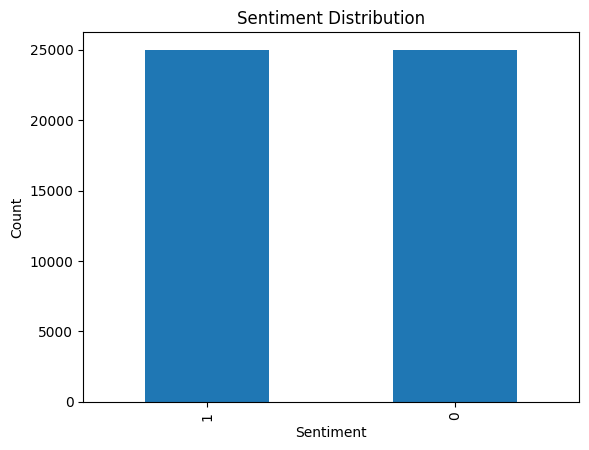

In [8]:
# step 8 - eda
import matplotlib.pyplot as plt

# Plot sentiment distribution
df['sentiment'].value_counts().plot(kind='bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


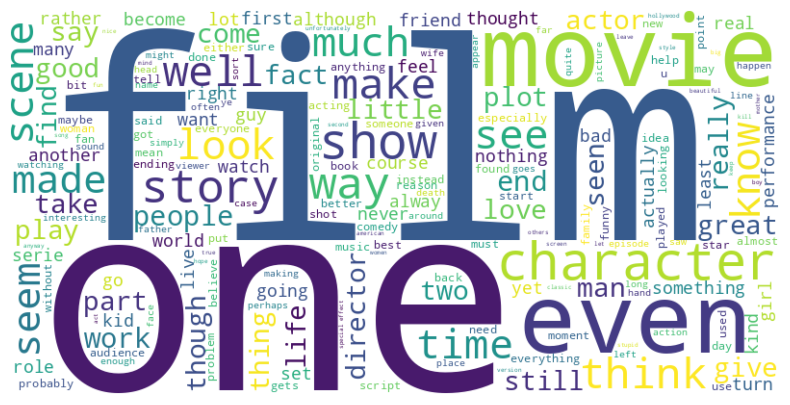

In [9]:
from wordcloud import WordCloud

# Generate and display word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(df['review']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


In [10]:
#step 9 - Support Vector Machine (SVM) Model
from sklearn.svm import SVC

# Train the SVM model
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_svm = svm.predict(X_test_tfidf)

# Evaluate the model
print("SVM Accuracy:", accuracy_score(y_test, y_pred_svm))
print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))


SVM Accuracy: 0.8824
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      4945
           1       0.88      0.89      0.88      5055

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In [11]:
# step 10 - Random Forest Model
from sklearn.ensemble import RandomForestClassifier

# Train the Random Forest model
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_rf = rf.predict(X_test_tfidf)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Random Forest Classification Report:")
print(classification_report(y_test, y_pred_rf))


Random Forest Accuracy: 0.8463
Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      4945
           1       0.86      0.84      0.85      5055

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



In [12]:
# step 11 - Gradient Boosting Model
import xgboost as xgb

# Train the XGBoost model
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_tfidf, y_train)

# Make predictions on the test set
y_pred_xgb = xgb_model.predict(X_test_tfidf)

# Evaluate the model
print("XGBoost Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("XGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [23:30:00] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8537
XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.84      0.85      4945
           1       0.84      0.87      0.86      5055

    accuracy                           0.85     10000
   macro avg       0.85      0.85      0.85     10000
weighted avg       0.85      0.85      0.85     10000



TypeError: 'int' object is not iterable

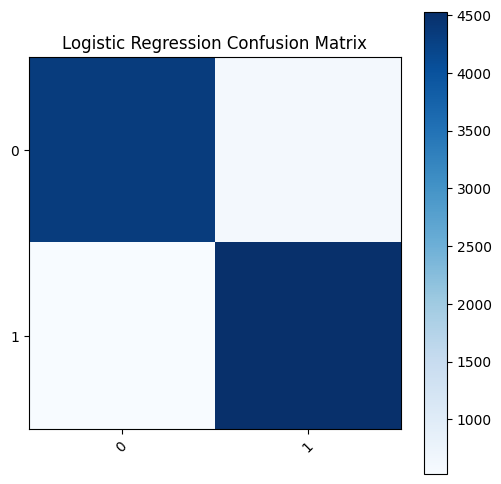

In [16]:
# viz 1 - Confusion Matrices
from sklearn.metrics import confusion_matrix
import itertools
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.figure(figsize=(6, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), cm.shape[1]):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()

# Plot confusion matrices for each model
models = {'Logistic Regression': logreg, 'Naive Bayes': nb, 'SVM': svm, 'Random Forest': rf, 'XGBoost': xgb_model}
for model_name, model in models.items():
    if model_name in ['Logistic Regression', 'Naive Bayes']:
        y_pred = model.predict(X_test_tfidf)
    else:
        y_pred = model.predict(X_test_tfidf.toarray())

    cm = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(cm, classes=[0, 1], title=f'{model_name} Confusion Matrix')
    plt.show()


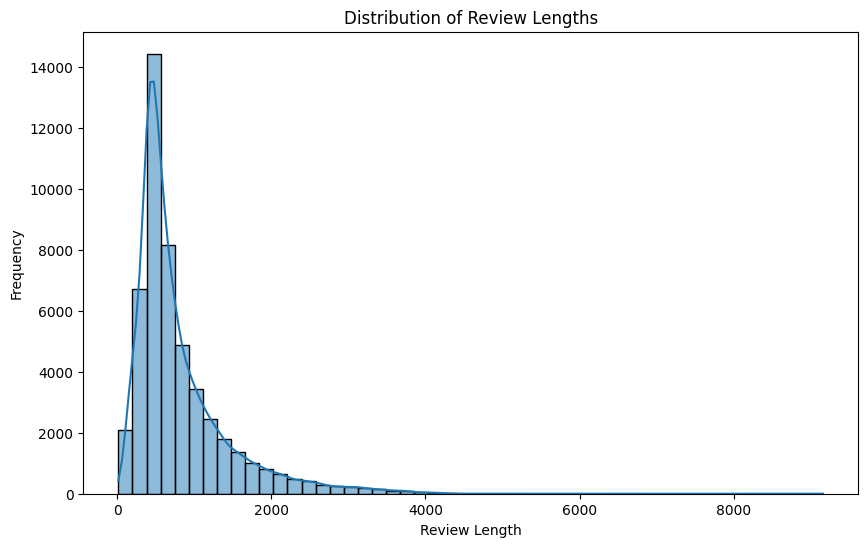

In [15]:
# viz 2 - Distribution of Review Lengths
# Calculate the length of each review
import seaborn as sns

df['review_length'] = df['review'].apply(len)

# Plot the distribution of review lengths
plt.figure(figsize=(10, 6))
sns.histplot(df['review_length'], bins=50, kde=True)
plt.title('Distribution of Review Lengths')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.show()


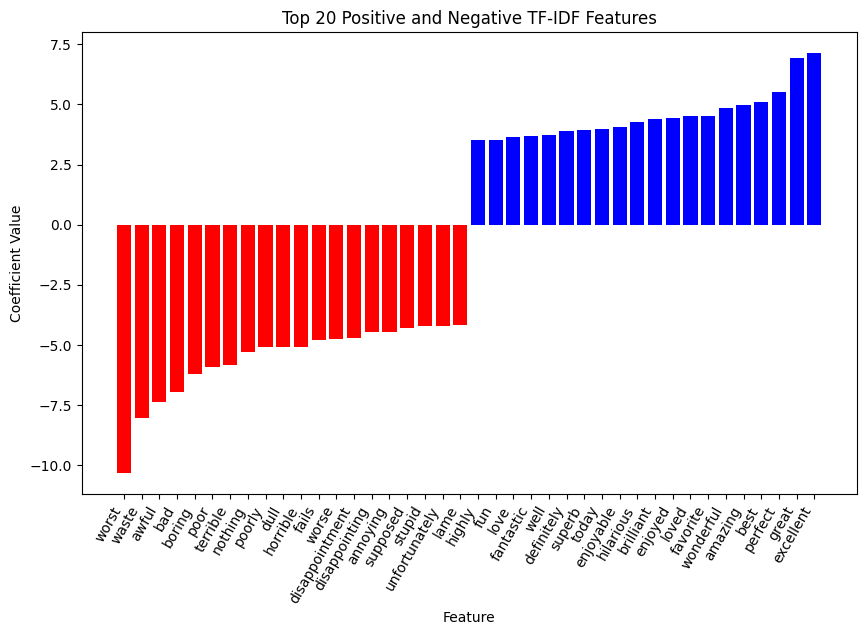

In [17]:
#viz 3 - TF-IDF Feature Importance
# Get feature names
feature_names = vectorizer.get_feature_names_out()

# Get coefficients for logistic regression model
coefficients = logreg.coef_.flatten()

# Get top 20 positive and negative features
top_positive_coefficients = np.argsort(coefficients)[-20:]
top_negative_coefficients = np.argsort(coefficients)[:20]
top_coefficients = np.hstack([top_negative_coefficients, top_positive_coefficients])

# Plot feature importance
plt.figure(figsize=(10, 6))
colors = ['red' if c < 0 else 'blue' for c in coefficients[top_coefficients]]
plt.bar(np.arange(2 * 20), coefficients[top_coefficients], color=colors)
feature_names_top = np.array(feature_names)[top_coefficients]
plt.xticks(np.arange(2 * 20), feature_names_top, rotation=60, ha='right')
plt.title('Top 20 Positive and Negative TF-IDF Features')
plt.xlabel('Feature')
plt.ylabel('Coefficient Value')
plt.show()


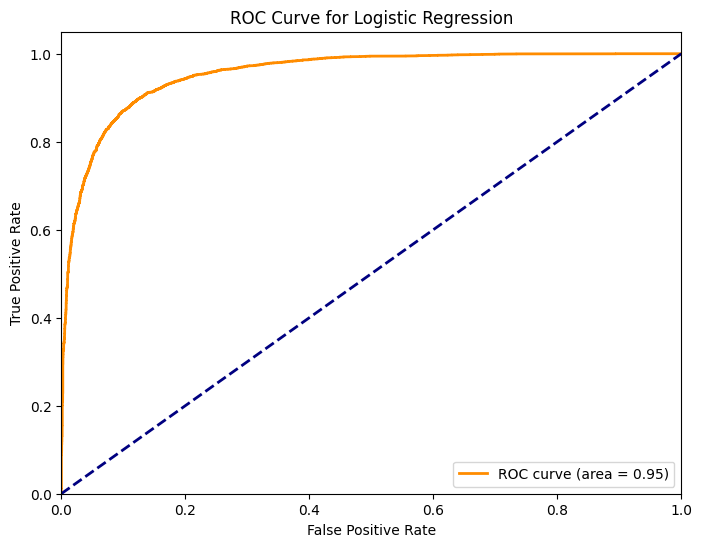

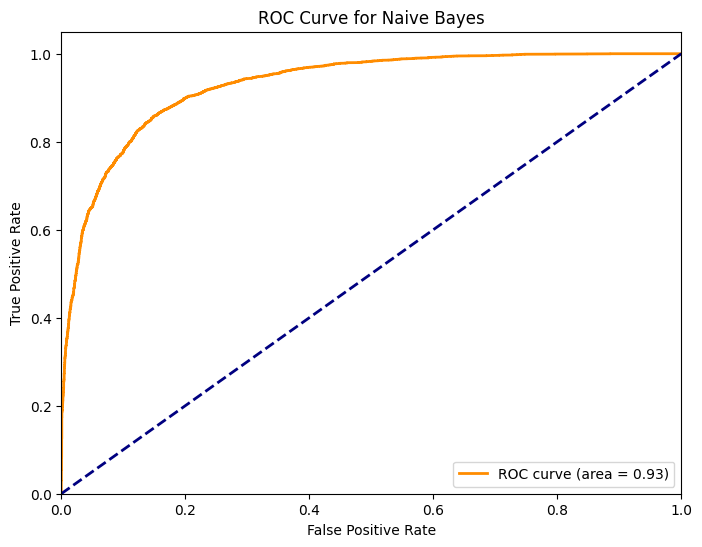

AttributeError: predict_proba is not available when probability=False

In [18]:
# viz 4 - ROC Curves
from sklearn.metrics import roc_curve, auc

# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc, model_name):
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.show()

# Plot ROC curves for each model
models = {'Logistic Regression': logreg, 'Naive Bayes': nb, 'SVM': svm, 'Random Forest': rf, 'XGBoost': xgb_model}
for model_name, model in models.items():
    if model_name in ['Logistic Regression', 'Naive Bayes']:
        y_pred_prob = model.predict_proba(X_test_tfidf)[:, 1]
    else:
        y_pred_prob = model.predict_proba(X_test_tfidf.toarray())[:, 1]

    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    plot_roc_curve(fpr, tpr, roc_auc, model_name)
